# MM-TIMEVIEW: Multimodal Extension of TIMEVIEW

This notebook demonstrates **MM-TIMEVIEW**, which extends the TIMEVIEW trajectory forecasting framework with **modality-level attribution** capabilities.

We evaluate MM-TIMEVIEW on multimodal clinical data to answer: *Which input modalities (demographics, biomarkers, imaging, etc.) drive the model's predictions for each patient?* This addresses a critical need in clinical AI systems where understanding the evidence basis for predictions is essential for trust and validation.

**Key addition**: Level 3 transparency - attributing predictions to specific input modalities using gradient-based methods.

For each sample, we compute modality importance scores through:

1. **Gradient-Input Product** at encoder output: $\alpha^{(k)} = \frac{\partial L}{\partial e^{(k)}} \odot e^{(k)}$

2. **L2 Pooling**: $\|\alpha^{(k)}\|_2$

3. **Normalization** to sum to 1: $a^{(k)} = \frac{\|\alpha^{(k)}\|_2}{\sum_m \|\alpha^{(m)}\|_2}$

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import Counter

sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.abspath('.'))))
sys.path.insert(0, '..')

device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cpu


## Load the FLChain Dataset

FLChain is a survival dataset with features from multiple modalities:
- **Demographics**: age, sex
- **FLC Biomarkers**: kappa, lambda, flc.grp (free light chain measurements)
- **Clinical**: creatinine, mgus (monoclonal gammopathy status)

In [2]:
os.chdir('../experiments')

from datasets import FLChainDataset

N_SAMPLES = 1000
dataset = FLChainDataset(subset=N_SAMPLES)
X, ts, ys = dataset.get_X_ts_ys()

print(f"\nFeatures: {dataset.get_feature_names()}")


Features: ['age', 'sex', 'creatinine', 'kappa', 'lambda', 'flc.grp', 'mgus']


In [3]:
modality_groups = {
    'Demographics': [0, 1],      # age, sex
    'FLC_Biomarkers': [3, 4, 5], # kappa, lambda, flc.grp  
    'Clinical': [2, 6]           # creatinine, mgus
}

feature_names = dataset.get_feature_names()
for mod_name, indices in modality_groups.items():
    feat_names = [feature_names[i] for i in indices]
    print(f"  {mod_name}: {feat_names}")

  Demographics: ['age', 'sex']
  FLC_Biomarkers: ['kappa', 'lambda', 'flc.grp']
  Clinical: ['creatinine', 'mgus']


## Preprocess Data

We use the dataset's built-in column transformer to handle both numerical and categorical features.

In [4]:
# Preprocess features
transformer = dataset.get_default_column_transformer()
X_np = X.values if hasattr(X, 'values') else X
X_scaled = transformer.fit_transform(X_np)

print(f"Original shape: {X_np.shape}")
print(f"After transformation: {X_scaled.shape}")

Original shape: (1000, 7)
After transformation: (1000, 16)


## Create MM-TIMEVIEW Model

The model has:
- **One encoder per modality**: Each transforms modality-specific features into an embedding
- **Fusion network**: Combines all embeddings to predict B-spline coefficients
- **B-spline basis**: Converts coefficients to trajectory predictions

In [5]:
os.chdir('..')

from mm_timeview import create_mm_timeview

N_BASIS = 9
T = 1.0
EMBEDDING_DIM = 16

model = create_mm_timeview(
    modality_groups=modality_groups,
    n_basis=N_BASIS,
    T=T,
    embedding_dim=EMBEDDING_DIM,
    seed=42
)

## Training

We train the model using MSE loss between predicted and actual trajectories.

In [6]:
from mm_timeview import train_mm_timeview

N_EPOCHS = 100

history = train_mm_timeview(
    model, X_scaled, ts, ys,
    n_epochs=N_EPOCHS,
    lr=0.01,
    batch_size=32,
    device=device
)

print(f"Final loss: {history['train_loss'][-1]:.6f}")

/Users/pietrobelligoli/MM-TIMEVIEW/experiments/../mm_timeview/model.py:283: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:219.)
  y_i = torch.from_numpy(ys[idx]).float().to(device)


Epoch  20/100 - Loss: 0.010378
Epoch  40/100 - Loss: 0.010483
Epoch  60/100 - Loss: 0.009690
Epoch  80/100 - Loss: 0.010351
Epoch 100/100 - Loss: 0.009773
Final loss: 0.009773


## Modality Attributions

The attribution is computed at **encoder outputs** $e^{(k)}$:
$$\alpha^{(k)} = \frac{\partial L}{\partial e^{(k)}} \odot e^{(k)}$$

In [7]:
from mm_timeview import (
    compute_modality_attributions,
    compute_attribution_statistics,
    print_attribution_summary
)

X_tensor = torch.from_numpy(X_scaled).float().to(device)

attributions = compute_modality_attributions(
    model=model,
    X=X_tensor,
    ts=ts,
    ys=ys,
    verbose=True
)

Computing attribution 100/1000
Computing attribution 200/1000
Computing attribution 300/1000
Computing attribution 400/1000
Computing attribution 500/1000
Computing attribution 600/1000
Computing attribution 700/1000
Computing attribution 800/1000
Computing attribution 900/1000
Computing attribution 1000/1000


In [8]:
stats = compute_attribution_statistics(attributions)
print_attribution_summary(stats)

Modality                   Mean        Std
Demographics             74.2%     13.6%
Clinical                 18.5%     10.2%
FLC_Biomarkers            7.2%      5.6%


## Visualize Results

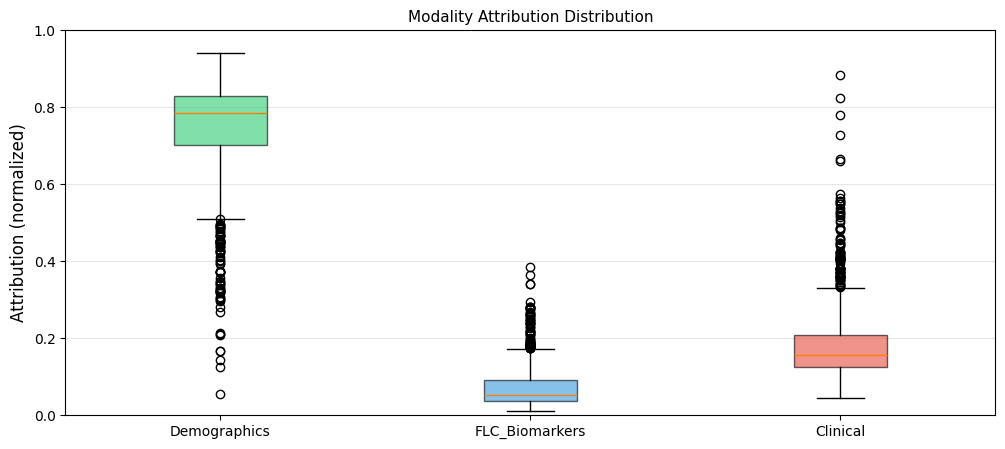

In [9]:
fig, ax = plt.subplots(figsize=(12, 5))

mod_names = list(modality_groups.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c']

attr_data = [attributions[m] for m in mod_names]
bp = ax.boxplot(attr_data, tick_labels=mod_names, patch_artist=True)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax.set_ylabel('Attribution (normalized)', fontsize=12)
ax.set_title('Modality Attribution Distribution', fontsize=11)
ax.set_ylim(0, 1)
ax.grid(True, alpha=0.3, axis='y')